In [ ]:
# import stuff!
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**** LOAD DATA ****

In [ ]:
from google import colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**PREPROCESS DATA**

,day sin,day cos,year sin,year cos,current demand,solar,wind,small hydro,nuclear,large hydro,batteries,imports,fossil
0,-7.003645e-19,1.414211,-0.000011,1.412278,-0.375645,-0.813978,0.677009,1.643686,0.720667,2.203055,-0.088897,0.244927,-0.798099
1,3.085086e-02,1.413875,0.000073,1.412278,-0.396562,-0.813978,0.645488,1.651537,0.718940,2.230985,0.047204,0.224320,-0.813176
2,6.168703e-02,1.412865,0.000158,1.412278,-0.412556,-0.813978,0.623192,1.549483,0.717214,2.238743,0.047204,0.191502,-0.815689
3,9.249385e-02,1.411183,0.000243,1.412278,-0.428141,-0.813978,0.638568,1.447430,0.715488,2.248828,0.047204,0.145709,-0.824233
4,1.232566e-01,1.408830,0.000327,1.412278,-0.444341,-0.813978,0.682391,1.533783,0.715488,2.245725,0.047204,0.127773,-0.849111


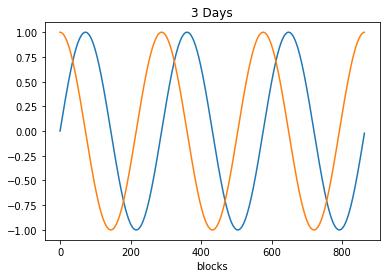

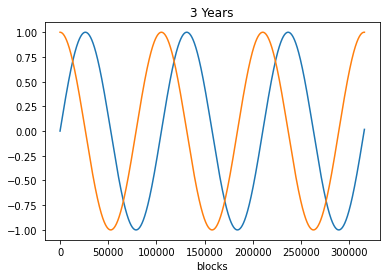

In [ ]:
#colab
demandDf = pd.read_csv("/content/drive/MyDrive/demand.csv")
sourcesDf = pd.read_csv("/content/drive/MyDrive/sources.csv")

# there is an anomaly on "small hydro", probably a mistake. 
#Values ..., 248, 400k, 248, ...
sourcesDf.loc[44191, 'small hydro'] = 248.0
sourcesDf = sourcesDf.drop(['time'], axis=1)


#demand concatenation
energy = pd.concat([demandDf['current demand'], sourcesDf], axis=1)
# fossil fuel sources
target = pd.DataFrame({'fossil': energy['coal'] + energy['natural gas']})
#drop fossil
energy =  energy.drop(['coal', 'natural gas'], axis=1)

                                ### CORRELATION ###
energy.corr('spearman')
energy = energy.drop(['geothermal', 'biomass', 'biogas', 'other'], axis=1)

                                ### ADDING TIME REFERENCE TO THE DATA ###
time = np.array(energy.index)
time_df = pd.DataFrame()
day_step=288

# day
time_df['day sin'] = np.sin( time * (2* np.pi / day_step) )
time_df['day cos'] = np.cos( time * (2* np.pi / day_step) )
#year
time_df['year sin'] = np.sin( time* (2*np.pi/ (365*day_step)))
time_df['year cos'] = np.cos( time* (2*np.pi/ (365*day_step)))

#3 days
plt.figure(1)
plt.title('3 Days')
plt.xlabel('blocks')
plt.plot(time_df['day sin'][0:day_step*3])
plt.plot(time_df['day cos'][0:day_step*3])
#3 years
plt.figure(2)
plt.title('3 Years')
plt.xlabel('blocks')
plt.plot(time_df['year sin'])
plt.plot(time_df['year cos'])

energy = pd.concat([time_df, energy], axis=1)

                                ### NORMALIZATION ###
sources = energy.copy()

# fossil fuel sources
t_mean = target.mean()[0]
t_std = target.std()[0]
target = (target - t_mean)/ t_std

sources = (sources -sources.mean())/ sources.std()

data = pd.concat([sources, target], axis=1)
data.head()

CREATE TRAIN - TEST DATA

In [ ]:
#  convert data to time series
# X - last hour
# Y - 1 next time step

# [[[t1], [t2], [t3]]] -> [[t4], [t5], [t6]] 
# [[[t2], [t3], [t4]]] -> [[t5], [t6], [t7]]
# [[[t3], [t4], [t5]]] -> [[t6], [t7], [t8]]

def df_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size):   
        
        row = [r for r in df_as_np[i: i+ window_size]] 
        X.append(row)
        #last value in row!
        label = df.iloc[i+window_size, -1]
        y.append(label)
    return np.array(X), np.array(y)



WINDOW_SIZE = 12 # 1 hour

X, y = df_X_y(data, WINDOW_SIZE)

# TRAIN VAL TEST - SPLIT 60% - 20% - 20%
step1 = int(0.6 * X.shape[0])
step2 = int(0.8* X.shape[0])

X_train, y_train = X[:step1], y[:step1]
X_val,   y_val   = X[step1:step2], y[step1:step2]
X_test,  y_test  = X[step2:], y[step2:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((189381, 12, 13),
 (189381,),
 (63127, 12, 13),
 (63127,),
 (63128, 12, 13),
 (63128,))

**MODEL SELECTION**

In [ ]:
## LSTM MODEL

lstm_model = tf.keras.models.Sequential([
                                     
  tf.keras.layers.InputLayer((12, 13)),

  tf.keras.layers.LSTM(256),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(256, 'relu'),
  tf.keras.layers.Dense(1, 'linear')                                     

])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               276480    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 342,529
Trainable params: 342,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError() , 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
## TRAINING
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1, callbacks=[early_stopping] )

Epoch 1/50
5919/5919 [==============================] - 34s 6ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 2/50
5919/5919 [==============================] - 32s 5ms/step - loss: 0.0469 - root_mean_squared_error: 0.2166 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
Epoch 3/50
5919/5919 [==============================] - 30s 5ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 4/50
5919/5919 [==============================] - 32s 5ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 5/50
5919/5919 [==============================] - 31s 5ms/step - loss: 0.0439 - root_mean_squared_error: 0.2096 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 6/50
5919/5919 [==============================] - 31s 5ms/step - loss: 0.0432 - root_mean_squared_error: 0.2078 - val_l

In [ ]:
## TESTING
test_pred = lstm_model.predict(X_test)
test_loss, test_rmse = lstm_model.evaluate(X_test, y_test)


1973/1973 [==============================] - 6s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516


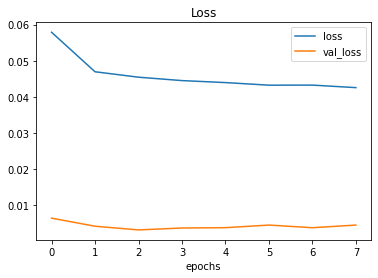

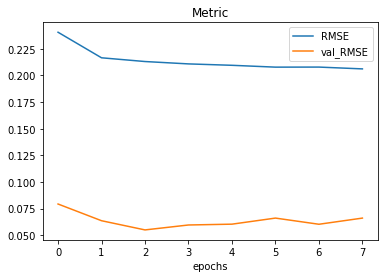

In [ ]:
plt.figure(1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.figure(2)
plt.title('Metric')
plt.xlabel('epochs')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='val_RMSE')
plt.legend()

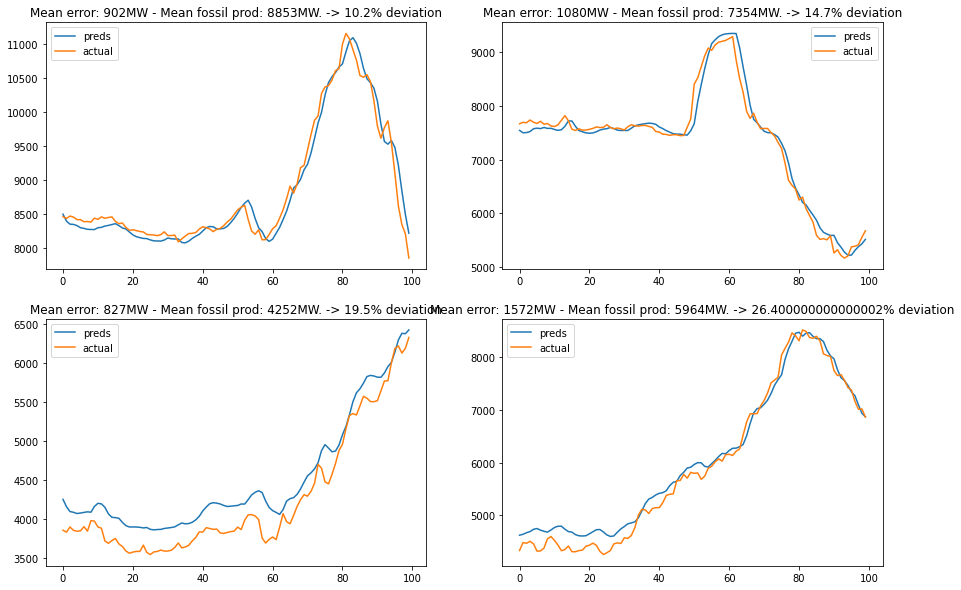

In [ ]:
# PLOT 200 POINTS
fig, ax = plt.subplots(2,2, figsize=(15, 10))

rand = np.random.randint(0, X_test.shape[0]+1)
testt_pred = test_pred[rand: rand+100] * t_std + t_mean
yy_test = y_test[rand: rand+100] * t_std + t_mean
ax[0,0].plot( testt_pred, label='preds')
ax[0,0].plot( yy_test, label ='actual')
err_ = np.abs(testt_pred - yy_test)
tmp = 100* round(err_.mean() / yy_test.mean(), 3) 
err_ = str(round(err_.mean() ))
act = str(round(yy_test.mean() ))
dev = str(tmp)
ax[0,0].set_title("Mean error: "+ err_ + "MW - Mean fossil prod: " + act+"MW. -> "+dev+"% deviation")
ax[0,0].legend()


rand = np.random.randint(0, X_test.shape[0]+1)
testt_pred = test_pred[rand: rand+100] * t_std + t_mean
yy_test = y_test[rand: rand+100] * t_std + t_mean
ax[0,1].plot( testt_pred, label='preds')
ax[0,1].plot( yy_test, label ='actual')
err_ = np.abs(testt_pred - yy_test)
tmp = 100* round(err_.mean() / yy_test.mean(), 3) 
err_ = str(round(err_.mean() ))
act = str(round(yy_test.mean() ))
dev = str(tmp)
ax[0,1].set_title("Mean error: "+ err_ + "MW - Mean fossil prod: " + act+"MW. -> "+dev+"% deviation")
ax[0,1].legend()


rand = np.random.randint(0, X_test.shape[0]+1)
testt_pred = test_pred[rand: rand+100] * t_std + t_mean
yy_test = y_test[rand: rand+100] * t_std + t_mean
ax[1,0].plot( testt_pred, label='preds')
ax[1,0].plot( yy_test, label ='actual')
err_ = np.abs(testt_pred - yy_test)
tmp = 100* round(err_.mean() / yy_test.mean(), 3) 
err_ = str(round(err_.mean() ))
act = str(round(yy_test.mean() ))
dev = str(tmp)
ax[1,0].set_title("Mean error: "+ err_ + "MW - Mean fossil prod: " + act+"MW. -> "+dev+"% deviation")
ax[1,0].legend()


rand = np.random.randint(0, X_test.shape[0]+1)
testt_pred = test_pred[rand: rand+100] * t_std + t_mean
yy_test = y_test[rand: rand+100] * t_std + t_mean
ax[1,1].plot( testt_pred, label='preds')
ax[1,1].plot( yy_test, label ='actual')
err_ = np.abs(testt_pred - yy_test)
tmp = 100* round(err_.mean() / yy_test.mean(), 3) 
err_ = str(round(err_.mean() ))
act = str(round(yy_test.mean() ))
dev = str(tmp)
ax[1,1].set_title("Mean error: "+ err_ + "MW - Mean fossil prod: " + act+"MW. -> "+dev+"% deviation")
ax[1,1].legend()

In [ ]:
#error in MW

y_mw = y_test.flatten() *t_std + t_mean
error = np.abs( test_pred.flatten() - y_test.flatten() ) * t_std

print('The mean error is: ', round(error.mean(), 2), ' Megawatts')
print('The mean fossil fuel energy productions is: ', round(y_mw.mean(), 2), ' Megawatts')
print('The standard dev. fossil fuel energy productions is: ', round(y_mw.std() , 2), ' Megawatts')
print('Mean deviation percentage: ', round(100*(error.mean() / y_mw.mean()), 2), '%')

The mean error is:  178.75  Megawatts
The mean fossil fuel energy productions is:  7873.18  Megawatts
The standard dev. fossil fuel energy productions is:  3018.9  Megawatts
Mean deviation percentage:  2.27 %
